## Clothes Classification with Deep Fashion 2 Dataset

### Import libraries

In [19]:
from typing import List

from skimage.io import imread, imshow
from skimage.transform import resize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

from masks import get_mask
from data_loader import load_training_df
from visualization import display_instances

### Read dataset

In [20]:
dataset_path = 'DeepFashion2Dataset'

In [5]:
def make_dataset_df(df):
    df['scale_categorical'] = df['scale'].map(
        {1: 'small_scale', 2: 'modest_scale', 3: 'large_scale'}
    )
    df['zoom_in_categorical'] = df['zoom_in'].map(
        {1: 'no_zoom_in', 2: 'medium_zoom_in', 3: 'large_zoom_in'}
    )
    df['viewpoint_categorical'] = df['viewpoint'].map(
        {1: 'no_wear', 2: 'frontal_viewpoint', 3: 'side_or_back_viewpoint'}
    )
    df['occlusion_categorical'] = df['occlusion'].map(
        {1: 'slight_occlusion', 2: 'medium_occlusion', 3: 'heavy_occlusion'}
    )
    
df = load_training_df(dataset_path, 'train')
make_dataset_df(df)

In [6]:
df.head()

segmentation  scale  viewpoint  \
id                                                                        
1   [[460, 438, 374, 484, 251, 520, 269, 586, 298,...      2          2   
1   [[257, 35, 261, 89, 228, 123, 137, 103, 45, 91...      3          2   
2   [[220.25, 187.55, 259.6, 177.6, 296.6, 158.6, ...      3          3   
2   [[145.21, 314.0, 162.67, 312.8, 175.12, 313.05...      3          2   
3   [[338, 64, 299, 133, 228, 189, 183, 121, 160, ...      3          1   

    zoom_in                                          landmarks  style  \
id                                                                      
1         3  [251, 520, 1, 374, 484, 1, 460, 438, 1, 269, 5...      0   
1         2  [182, 54, 1, 45, 91, 1, 137, 103, 1, 228, 123,...      1   
2         1  [271, 172, 2, 313, 145, 2, 0, 0, 0, 0, 0, 0, 0...      2   
2         2  [127, 335, 1, 73, 340, 1, 107, 354, 1, 140, 35...      1   
3         2  [240, 108, 2, 160, 63, 2, 183, 121, 2, 228, 18...      1   

            bounding_box  category_id  occlusion      category_name source  \
id                                                                           
1   [249, 423, 466, 623]            8          2           trousers   user   
1      [0, 29, 466, 622]            1          2   short sleeve top   user   
2   [165, 133, 466, 572]            1          2   short sleeve top   shop   
2     [1, 300, 367, 701]            1          2   short sleeve top   shop   
3      [1, 52, 467, 831]           11          1  long sleeve dress   user   

    pair_id                                  image_path scale_categorical  \
id                                                                          
1         1  DeepFashion2Dataset/train/image/000001.jpg      modest_scale   
1         1  DeepFashion2Dataset/train/image/000001.jpg       large_scale   
2         1  DeepFashion2Dataset/train/image/000002.jpg       large_scale   
2         1  DeepFashion2Dataset/train/image/000002.jpg       large_scale   
3         2  DeepFashion2Dataset/train/image/000003.jpg       large_scale   

   zoom_in_categorical   viewpoint_categorical occlusion_categorical  
id                                                                    
1        large_zoom_in       frontal_viewpoint      medium_occlusion  
1       medium_zoom_in       frontal_viewpoint      medium_occlusion  
2           no_zoom_in  side_or_back_viewpoint      medium_occlusion  
2       medium_zoom_in       frontal_viewpoint      medium_occlusion  
3       medium_zoom_in                 no_wear      slight_occlusion

### Data Visualisation

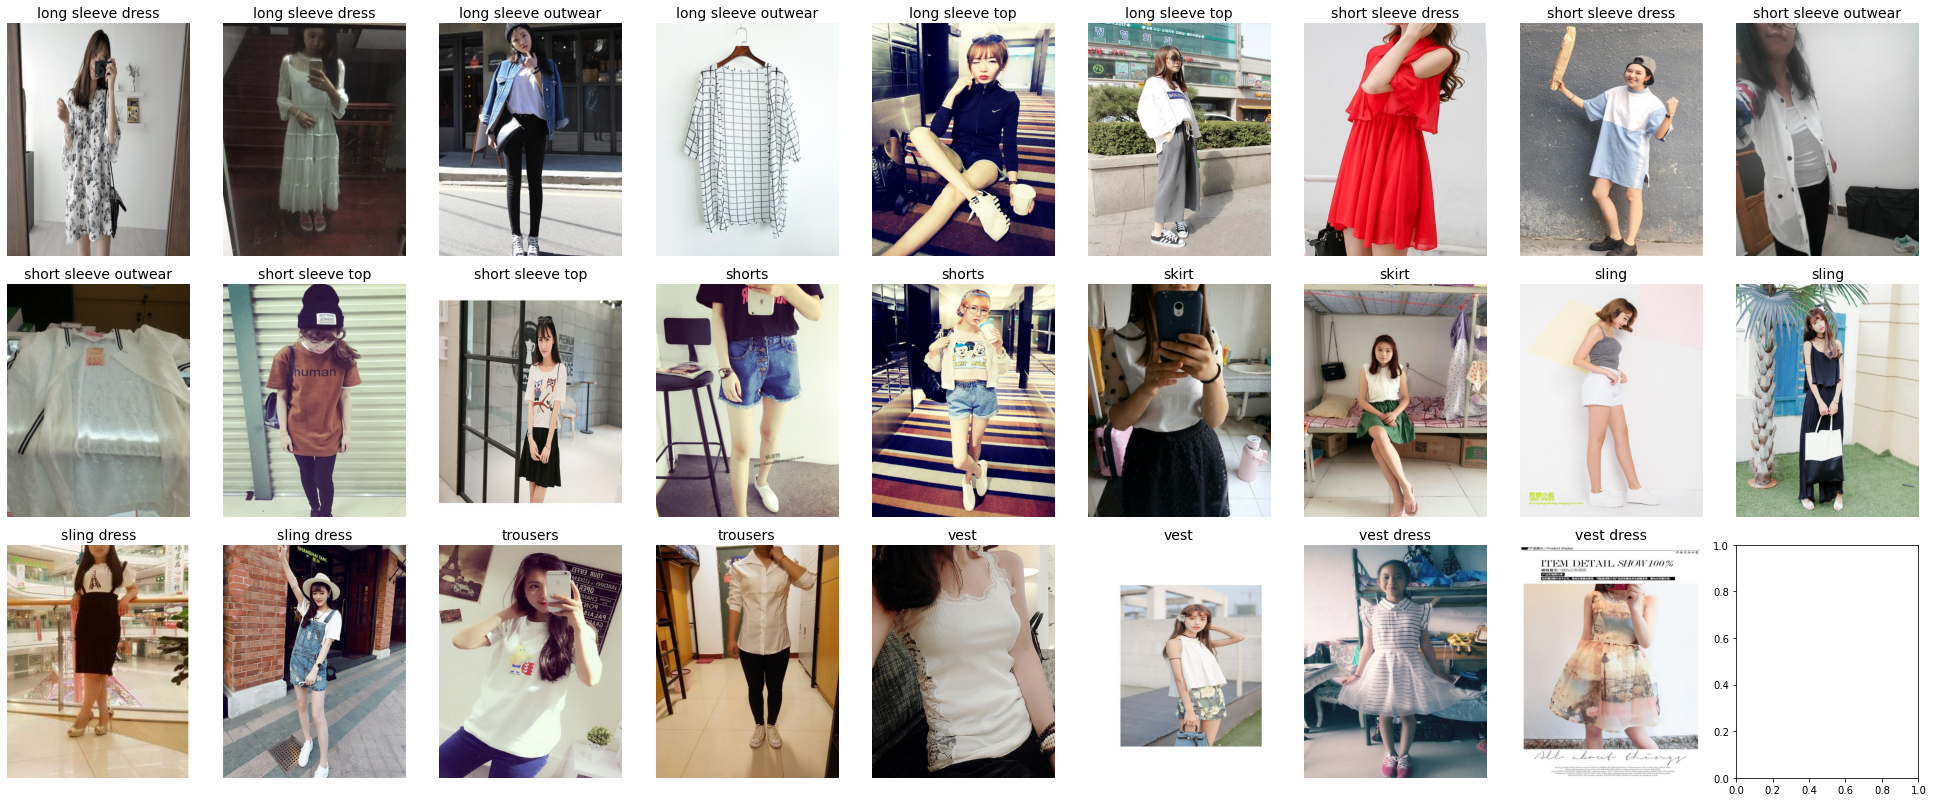

In [21]:
def _samples_per_category(df: pd.DataFrame,
                          column: str,
                          n_samples: int = 7) -> pd.DataFrame:
    return df.groupby(column)\
             .apply(lambda x: x.sample(n_samples))\
             .reset_index(level=0, drop=True)\
             .reset_index()
    

column = 'category_name'
display_instances(_samples_per_category(df, column, n_samples=2),
                  title_column=column,
                  n_cols=9)

<AxesSubplot:>

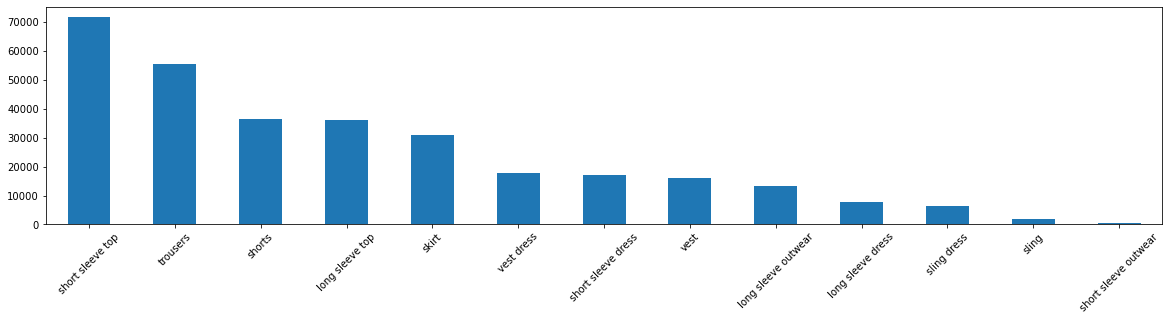

In [22]:
df[column].value_counts().plot.bar(figsize=(20, 4), rot=45)

### Apply Masks

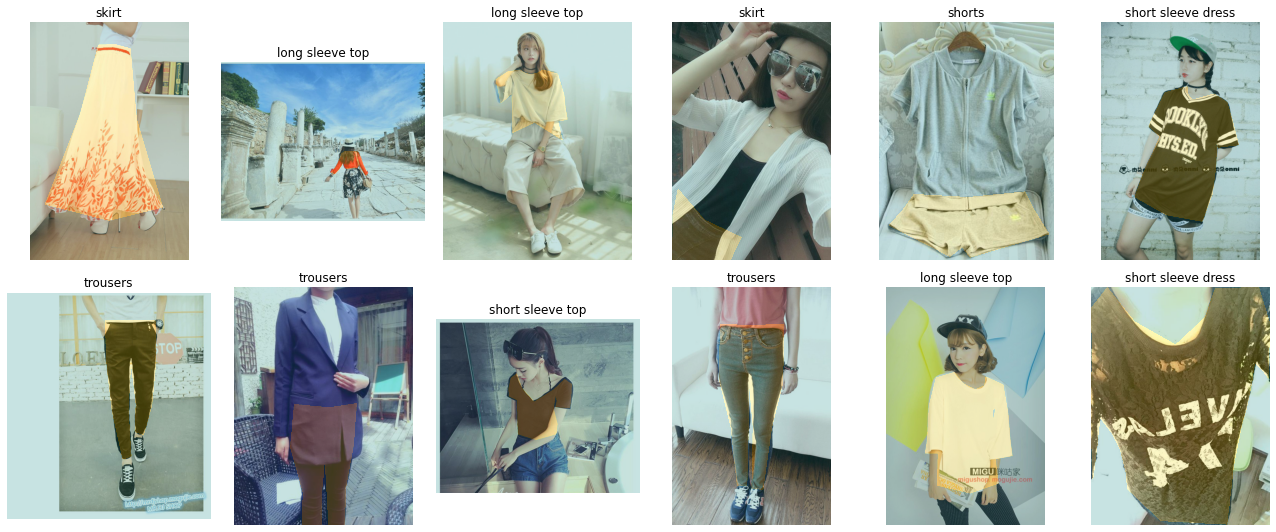

In [24]:
def _display_masks(image: np.ndarray, masks: List, ax=None):
    # Display image
    if ax is not None:
        axis = ax
    else:
        plt.figure(figsize=(8, 15))
        axis = plt
    axis.imshow(image)
    
    # Display all masks
    for mask in masks:
        axis.imshow(mask, alpha=0.25, vmin=-1.0, vmax=1.0)

        
def instance_to_mask(row: pd.Series) -> np.ndarray:
    image = imread(row['image_path'])
    image_height, image_width = image.shape[:2]
    return get_mask(image_height,
                    image_width,
                    polygons=row['segmentation'],
                    category_id=int(row['category_id']))


def display_instance_mask(row: pd.Series, ax) -> None:
    masks = [instance_to_mask(row)]
    image = imread(row['image_path'])
    _display_masks(image, masks, ax=ax)
    ax.set_title(row["category_name"])
    ax.axis('off')
    
samples = df.sample(12)
display_instances(samples, display_fn=display_instance_mask, n_cols=6)

#### All the masks on the images

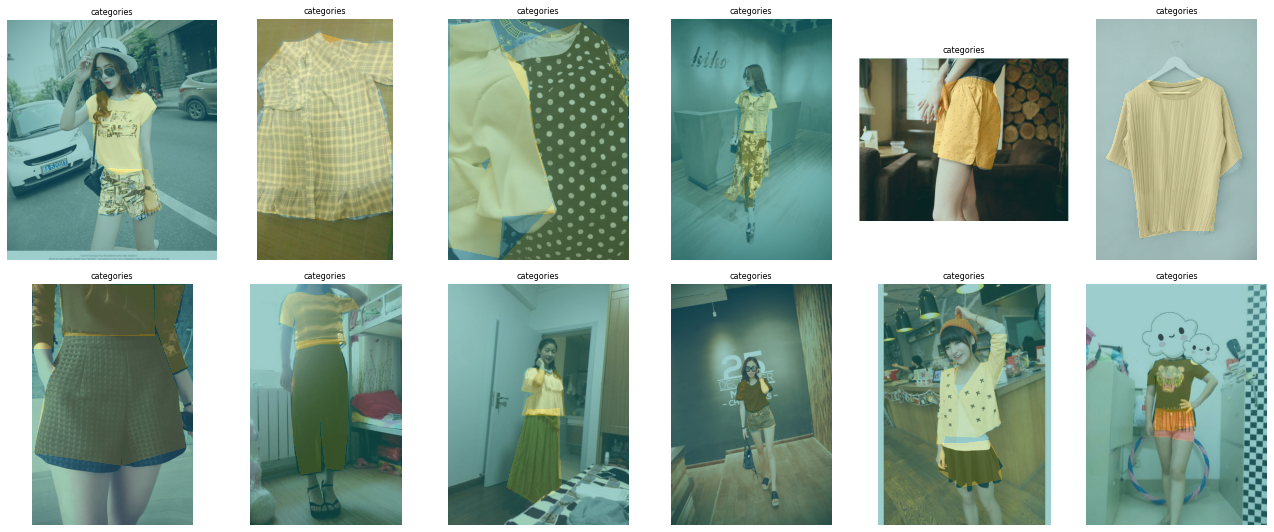

In [25]:
def display_all_instance_masks(row: pd.Series, ax) -> None:
    items = df[df.index == row.name]
    masks = items.apply(instance_to_mask, axis=1).values.tolist()
    image = imread(row['image_path'])
    _display_masks(image, masks, ax=ax)
    # Displau call categories
    categories = items["category_name"].values.tolist()
    ax.set_title('categories', fontsize=8)
    ax.axis('off')

samples = df.sample(12)
display_instances(samples, display_fn=display_all_instance_masks, n_cols=6)

### Initialize a model

In [ ]:
print('Initializing model from scratch')

# constants
img_width = 128
img_height = 128
n_channels = 3 # rgb
n_classes = 13 # cathegories

#### Unet

In [11]:
import tensorflow as tf

In [12]:
inputs = tf.keras.layers.Input((img_width, img_height, n_channels))

# to floats
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
c1 = tf.keras.layers.Conv2D(
    filters = 16,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(
    filters = 16,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)


c2 = tf.keras.layers.Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)


c3 = tf.keras.layers.Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(
    filters = 128,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = tf.keras.layers.Conv2D(
    filters = 256,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(
    filters = 256,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c5)

We are down of the U model.

In [13]:
u6 = tf.keras.layers.Conv2DTranspose(
    filters = 128,
    kernel_size = (2, 2),
    strides = (2, 2),
    padding='same'
)(c5)
u6 = tf.keras.layers.concatenate([u6, c4])

c6 = tf.keras.layers.Conv2D(
    filters = 128,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(
    filters = 128,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c6)

u7 = tf.keras.layers.Conv2DTranspose(
    filters = 64,
    kernel_size = (2, 2),
    strides = (2, 2),
    padding='same'
)(c6)

u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(
    filters = 64,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c7)

u8 = tf.keras.layers.Conv2DTranspose(
    filters = 32,
    kernel_size = (2, 2),
    strides = (2, 2),
    padding='same'
)(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(
    filters = 32,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c8)

u9 = tf.keras.layers.Conv2DTranspose(
    filters = 16,
    kernel_size = (2, 2),
    strides = (2, 2),
    padding='same'
)(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(
    filters = 16,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(
    filters = 16,
    kernel_size = (3, 3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
)(c9)

outputs = tf.keras.layers.Dropout(0.1875)(c9) # make 13
outputs = tf.keras.layers.Conv2D(
    filters=n_classes, # 13 
    kernel_size=(1, 1),
    strides=(1, 1),
    padding='same'
)(outputs)

In [14]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

---

### Prepare the data for training

In [56]:
X_train = np.zeros((len(df), img_height, img_width, n_channels), dtype=np.uint8)
Y_train = np.zeros((len(df), img_height, img_width, 1), dtype=np.float)

In [57]:
print('Resize the images:')
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

def random_crop(image, mask, image_size):
    crop_params = transforms.RandomCrop.get_params(image,
            output_size=(image_size, image_size)
    )
    start_y, start_x, new_height, new_width = crop_params
    # Apply crop given computed paddings
    image = TF.crop(image, start_y, start_x, new_height, new_width)
    mask = TF.crop(mask, start_y, start_x, new_height, new_width)
    return image, mask

def augment(self, image, mask):
    central_crop_size = 512
    # Color and illumination changes
    image = transforms.ColorJitter(brightness=0.1,
                                   contrast=0.1,
                                   saturation=0.1,
                                   hue=0.05)(image)

    # Random crop the image
    image, mask = random_crop(image, mask, central_crop_size)

    # Random horizontal flipping
    if random.random() > 0.5:
        image, mask = TF.hflip(image), TF.hflip(mask)
    return image, mask

def resize_image(img: np.ndarray, new_size: int) -> np.ndarray:
    # skimage.transform
    return resize(img,
                  (new_size, new_size),
                  mode='constant',
                  preserve_range=True,
                  order=0).astype('uint8')

def resize_mask(mask: np.ndarray, new_size: int) -> np.ndarray:
    return resize(mask,(new_size, new_size),
                    order=0,  # mode=nearest
                    anti_aliasing=False,
                    preserve_range=True).astype('uint8')

def transform(image, mask, data_augmentation):
    data_augmentation = None
    image = TF.to_pil_image(resize_image(image, img_width))
    mask = TF.to_pil_image(resize_mask(mask, img_width))

    if data_augmentation is not None:
        image, mask = augment(image, mask)

    # Image normalization
#     image = transforms.ToTensor()(image)
#     image = transforms.Normalize(mean=(0,), std=(1,))(image)
    return image, np.array(mask)

Resize the images:


In [ ]:
data_augmentation = None

for index, row in tqdm(df.iterrows()):
#     if index == 1000:
#         break
    mask = instance_to_mask(row)
    image = imread(row['image_path'])
    image, mask = transform(image, mask, data_augmentation)
    mask = np.expand_dims(mask, axis=-1)
    X_train[index-1] = image
    Y_train[index-1] = mask


162633it [3:04:54, 15.85it/s]

In [ ]:
imshow(np.squeeze(X_train[1]))
plt.show()
imshow(np.squeeze(Y_train[1]))
plt.show()

In [ ]:
# Model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_deep_fashion_v1.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

results = model.fit(
    X_train,
    Y_train,
    validation_split=0.9,
    batch_size=16, 
    epochs=5, 
    callbacks=callbacks
)

In [53]:
results

NameError: name 'results' is not defined

### Validation Data Preparation

In [7]:
df_valid = load_training_df(dataset_path, 'validation')
make_dataset_df(df_valid)

In [8]:
df_valid.head()

segmentation  scale  viewpoint  \
id                                                                        
1   [[209.98022762018, 194.9419398675046, 213.5474...      1          2   
1   [[218.92420634920632, 189.49960317460315, 209....      1          2   
2   [[181.15714285714282, 133.01428571428576, 188....      2          2   
2   [[194.9765873015873, 122.92420634920632, 181.6...      1          2   
3   [[222.0721153846154, 252.40660866910866, 218.0...      1          2   

    zoom_in                                          landmarks  style  \
id                                                                      
1         1  [247, 260, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2   
1         1  [238, 195, 1, 219, 189, 1, 225, 197, 1, 238, 2...      1   
2         1  [235, 203, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      2   
2         1  [218, 124, 1, 195, 123, 1, 205, 130, 1, 219, 1...      1   
3         1  [220, 250, 1, 207, 246, 1, 211, 258, 1, 220, 2...      1   

            bounding_box  category_id  occlusion       category_name source  \
id                                                                            
1   [204, 189, 293, 414]           13          2         sling dress   user   
1   [199, 190, 287, 269]            5          2                vest   user   
2   [176, 120, 292, 383]           13          2         sling dress   user   
2   [170, 121, 280, 215]            5          2                vest   user   
3   [151, 241, 279, 435]           10          2  short sleeve dress   user   

    pair_id                                       image_path  \
id                                                             
1         1  DeepFashion2Dataset/validation/image/000001.jpg   
1         1  DeepFashion2Dataset/validation/image/000001.jpg   
2         1  DeepFashion2Dataset/validation/image/000002.jpg   
2         1  DeepFashion2Dataset/validation/image/000002.jpg   
3         3  DeepFashion2Dataset/validation/image/000003.jpg   

   scale_categorical zoom_in_categorical viewpoint_categorical  \
id                                                               
1        small_scale          no_zoom_in     frontal_viewpoint   
1        small_scale          no_zoom_in     frontal_viewpoint   
2       modest_scale          no_zoom_in     frontal_viewpoint   
2        small_scale          no_zoom_in     frontal_viewpoint   
3        small_scale          no_zoom_in     frontal_viewpoint   

   occlusion_categorical  
id                        
1       medium_occlusion  
1       medium_occlusion  
2       medium_occlusion  
2       medium_occlusion  
3       medium_occlusion

In [54]:
X_valid = np.zeros((len(df_valid), img_height, img_width, n_channels), dtype=np.uint8)
Y_valid = np.zeros((len(df_valid), img_height, img_width, 1), dtype=np.float)

In [55]:
data_augmentation = None

for index, row in tqdm(df_valid.iterrows()):
    mask = instance_to_mask(row)
    image = imread(row['image_path'])
    image, mask = transform(image, mask, data_augmentation)
    mask = np.expand_dims(mask, axis=-1)
    X_valid[index-1] = image
    Y_valid[index-1] = mask


0it [00:00, ?it/s]


NameError: name 'skimage' is not defined